In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.neighbors import NearestNeighbors
from scipy.stats import dirichlet, norm

In [201]:
class DataGenerator:
    def __init__(self, n_cells, n_cell_types, n_genes, K, epsilon=0.25):
        self.n_cells = n_cells
        self.n_cell_types = n_cell_types
        self.n_genes = n_genes
        self.K = K
        self.epsilon = epsilon

        self.graph = None
        self.coordinates = None
        self.neighbors_cell_types = None
        self.perturbation = None
        self.expression = None
        self.cell_types = None
        
        self.reset()

    def reset(self):
        self.generate_cell_caracteristics()
        self.generate_perturbation()
        self.generate_knn_graph()
        self.generate_cell_types()
        self.generate_perturbed_caracteristics()

    def generate_knn_graph(self):
        self.coordinates = np.random.uniform(size=(self.n_cells, 2))
        nn = NearestNeighbors(self.K + 1)
        nn.fit(self.coordinates)
        self.graph = nn.kneighbors(self.coordinates, self.K + 1)[1][:, 1:]

    def generate_cell_types(self):
        self.cell_types = np.random.choice(self.n_cell_types, size=self.n_cells)
        self.neighbors_cell_types = np.zeros((self.n_cells, self.n_cell_types))
        for i in range(self.n_cells):
            cell_types, counts = np.unique(
                self.cell_types[self.graph[i]], return_counts=True
            )
            self.neighbors_cell_types[i][cell_types] = counts / self.K

    def generate_perturbation(self):
        shape = (self.n_cell_types, self.n_cell_types, self.n_genes)
        self.perturbation = np.random.normal(0, 10, size=shape)

    def generate_cell_caracteristics(self):
        shape = self.n_cell_types, self.n_genes
        self.initial_cell_carac = np.random.normal(0, 10, size=shape)

    def generate_perturbed_caracteristics(self):
        effective_perturbation = (
            self.perturbation[self.cell_types]
            * self.neighbors_cell_types[:, :, np.newaxis]
        ).sum(axis=1)

        self.effective_gene_expression = (
            self.initial_cell_carac[self.cell_types]
            + self.epsilon * effective_perturbation
        )

    def generate_gene_expression(self, epsilon=None, n_cells=None):
        # If epsilon or n_cells is given, resample accordingly without changing the
        # global latent variable about cluster mean, cluster interactions
        if n_cells is not None:
            self.n_cells = n_cells
            self.generate_knn_graph()
            self.generate_cell_types()

        if epsilon is not None:
            self.epsilon = epsilon
            self.generate_perturbed_caracteristics()

        self.observations = np.random.normal(self.effective_gene_expression, 1)
        return self.observations
    

In [226]:
"""
Potentiels bugs:
    - Variance vs std
    - rho: echange des deux premieres dimensions (i et k)
    - code immonde
"""


class GibbsSampler:
    def __init__(
        self, num_cells, num_cell_types, num_genes, sigma, S, epsilon, graph, alpha=None
    ):
        self.num_cells = num_cells
        self.num_cell_types = num_cell_types
        self.num_genes = num_genes
        self.epsilon = epsilon
        self.graph = graph
        self.epsilon_up = self.epsilon / self.graph.shape[1]
        self.sigma = sigma
        self.S = S
        if alpha is None:
            alpha = np.ones(num_cell_types)
        self.alpha = alpha
        self.reset()

    def reset(self):
        self.pi = np.random.dirichlet(self.alpha)
        self.update_Z(
            np.random.choice(self.num_cell_types, p=self.pi, size=self.num_cells)
        )
        self.beta = np.random.normal(
            0, self.sigma, size=(self.num_cell_types, self.num_genes)
        )
        self.rho = np.random.normal(
            0,
            self.sigma,
            size=(self.num_cell_types, self.num_cell_types, self.num_genes),
        )
        self.log_joints = []

    def update_Z(self, Z):
        self.Z = Z.astype(int)
        self.n_i = np.array(
            [sum([1 for z in self.Z if z == i]) for i in range(self.num_cell_types)]
        )

    def sample_pi(self):
        return np.random.dirichlet(self.alpha + self.n_i)

    def sample_beta(self, x):
        multipliers = self.sigma ** 2 / (self.S ** 2 + self.n_i * self.sigma ** 2)
        variances = (self.S ** 2) * multipliers
        alphas = np.array(
            [
                np.sum(x * (self.Z == i)[:, None], axis=0)
                - self.epsilon_up
                * np.sum(
                    np.sum(
                        self.rho[i, self.Z[self.graph], :] * (self.Z == i)[:, None, None],
                        axis=0,
                    ),
                    axis=0,
                )
                for i in range(self.num_cell_types)
            ]
        )
        return np.random.normal(
            multipliers[:, None] * alphas, np.sqrt(variances)[:, None]
        )

    def sample_rho(self, x):
        m = np.array(
            [
                np.sum((self.Z[self.graph] == i), axis=1)
                for i in range(self.num_cell_types)
            ]
        ).T
        eta = np.array(
            [
                1
                / (
                    self.S ** 2 / (self.sigma ** 2)
                    + (self.epsilon_up ** 2)
                    * np.sum((m**2) * (self.Z == i)[:, None], axis=0)
                )
                for i in range(self.num_cell_types)
            ]
        )
        t = self.epsilon_up * np.array(
            [
                [
                    np.sum(
                        (
                            m[:, k, None]
                            * (
                                x
                                - self.beta[i, None, :]
                                - self.epsilon_up*np.sum(
                                    self.rho[i, self.Z[self.graph], :]
                                    * (self.Z[self.graph] != k)[:, :, None],
                                    axis=1,
                                )
                            )
                        )
                        * (self.Z == i)[:, None],
                        axis=0,
                    )
                    for k in range(self.num_cell_types)
                ]
                for i in range(self.num_cell_types)
            ]
        )
        return np.random.normal(
            eta[:, :, None] * t, np.sqrt((self.S ** 2) * eta[:, :, None])
        )

    def sample_Z(self, x):
        log_val = np.array(
            [
                [
                    self._log_joint(
                        x, self.Z + (k - self.Z[i]) * (np.arange(self.num_cells) == i)
                    )
                    for k in range(self.num_cell_types)
                ]
                for i in range(self.num_cells)
            ]
        )

        log_vals =log_val - np.max(log_val, axis=1)[:, None]
        probas = np.exp(log_vals) / np.sum(np.exp(log_vals), axis=1)[:, None]
        return np.array(
            [
                np.random.choice(np.arange(self.num_cell_types), p=probas[v])
                for v in range(self.num_cells)
            ]
        )

    """
        This function computes the log-joint for a specified Z, which is used while sampling Z. 
        To get the log-joint for the current value of the parameters, use log_joint
    """

    def _log_joint(self, x, Z, should_print = False):
        temp = (
            dirichlet.logpdf(self.pi, self.alpha)
            + np.sum(np.log(self.pi[Z]))
            + np.sum(norm.logpdf(self.beta, 0, self.sigma))
            + np.sum(norm.logpdf(self.rho, 0, self.sigma))
        )
        loc = np.array(
            [
                self.beta[Z[v], :]
                + self.epsilon_up * np.sum(self.rho[Z[v], Z[self.graph[v]], :], axis=0)
                for v in range(self.num_cells)
            ]
        )
        return temp + np.sum(norm.logpdf(x, loc, self.S * np.ones(loc.shape)))

    def log_joint(self, x):
        return self._log_joint(x, self.Z, True)

    def train(self, num_epochs, x):
        for _ in range(num_epochs):
            self.update_Z(self.sample_Z(x))
            self.pi = self.sample_pi()
            self.beta = self.sample_beta(x)
            self.rho = self.sample_rho(x)
            self.log_joints.append(self.log_joint(x))

    def plot(self):
        plt.plot(np.arange(len(self.log_joints)), self.log_joints)

In [316]:
n_cells = 80
n_cell_types = 3
n_genes = 5
K = 2
epsilon = 0.2

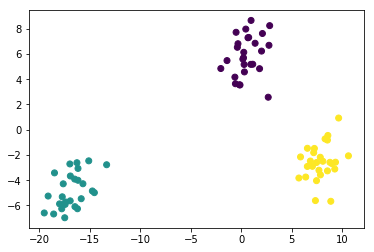

In [317]:
np.random.seed(4)
dg = DataGenerator(n_cells, n_cell_types, n_genes, K, epsilon)
expression = dg.generate_gene_expression(epsilon, n_cells)

plt.scatter(*expression.T[:2], c=dg.cell_types)

In [318]:
sampler = GibbsSampler(n_cells, n_cell_types, n_genes, 10, 1, epsilon, dg.graph)

In [319]:
sampler.train(100, expression)

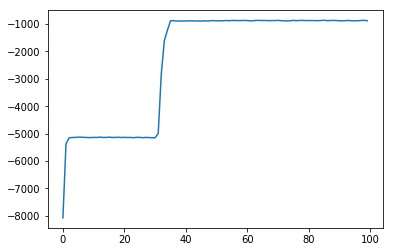

In [320]:
sampler.plot()

In [314]:
sampler.rho[1,1]

array([  1.72825274,  -0.41392633,  14.78665056,   3.90818533,
       -11.16320276])

In [315]:
dg.perturbation[0,0]

array([ 3.50997153, -6.06887283, 15.46979329,  7.23341609,  0.46135567])

In [307]:
dg.cell_types

array([1, 0, 2, 0, 1, 2, 1, 2, 1, 0, 2, 2, 0, 0, 2, 2, 2, 2, 1, 2, 0, 2,
       1, 2, 1, 1, 2, 0, 0, 0, 1, 2, 0, 1, 0, 1, 1, 2, 1, 0, 2, 0, 1, 2,
       0, 1, 2, 0, 0, 1, 2, 2, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 2, 1, 2,
       1, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 0, 2])

In [305]:
sampler.Z

array([0, 1, 2, 1, 0, 2, 0, 2, 0, 1, 2, 2, 1, 1, 2, 2, 2, 2, 0, 2, 1, 2,
       0, 2, 0, 0, 2, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 2, 0, 1, 2, 1, 0, 2,
       1, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 2, 0, 0,
       0, 2, 2, 2, 1, 1, 1, 1, 0, 1, 1, 0, 1, 2])

In [310]:
sampler.beta[1]

array([ 1.45096403,  5.36956669, -9.73152428,  9.13139457, -4.48924124])

In [311]:
dg.initial_cell_carac[0]

array([ 0.50561707,  4.99951333, -9.95908931,  6.93598508, -4.1830152 ])